In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
                'marital-status', 'occupation', 'relationship', 'race', 'gender',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']


adult_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

adult_test_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier

from joblib import dump, load
from sklearn.model_selection import cross_val_score
import sys
import time



In [8]:
def performance_metrics(y_true, y_pred):
    
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    false_pos = FP/(FP+TN)
    
    metrics = {}
    metrics['accuracy'] =  accuracy
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f_measure'] = f_measure
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['error_rate'] = error_rate
    metrics['false_pos'] = false_pos
    
    return metrics

In [3]:
def adult_preprocess(df, balanced=False, impute=False):
    """adult_preprocess(df, balanced=False, impute=False)
            balanced: will sample an even amount of data from each
    
            impute:
                Imputes missing data using random forest,
                or removes rows with missing data
                
        expands categorical data returns X and Y arrays"""
    #drop columns
    drop_columns = ["fnlwgt"]
    df = df.drop(drop_columns , axis=1)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import tree
    
    
    if impute:
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.workclass
        impute_df.drop(columns = ['workclass'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.workclass.values == '?')].copy()
        
        train_data = impute_df[(df.workclass.values != '?')].copy()
        train_label = impute_labels[(df.workclass.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.workclass.values == '?'),'workclass'] = random_forest_pred
        
        #repeat for occupation
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.occupation
        impute_df.drop(columns = ['occupation'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.occupation.values == '?')].copy()
        
        train_data = impute_df[(df.occupation.values != '?')].copy()
        train_label = impute_labels[(df.occupation.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.occupation.values == '?'),'occupation'] = random_forest_pred
        
        # repeat for native-country
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df['native-country']
        impute_df.drop(columns = ['native-country'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df['native-country'].values == '?')].copy()
        
        train_data = impute_df[(df['native-country'].values != '?')].copy()
        train_label = impute_labels[(df['native-country'].values != '?')]
     
        random_forest = tree.DecisionTreeClassifier()
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df['native-country'].values == '?'),'native-country'] = random_forest_pred    
    else:
        # remove rows with '?'s
        df = df[(df != '?').all(1)]
    
    # convert categorical data into one-hot
    df_one_hot = pd.get_dummies(df)
    
    # sample equal number of plus and minus
    if balanced:
        # find number of income > $50k
        sample_number = len(df_one_hot[df_one_hot['income_>50K'] == 1])
        df_over_50k = df_one_hot[df_one_hot['income_>50K'] == 1].sample(n=sample_number, random_state=0)
        df_under_50k = df_one_hot[df_one_hot['income_>50K'] == 0].sample(n=sample_number, random_state=0)
        frames = [df_over_50k, df_under_50k]
        df_clean = pd.concat(frames)
    else:
        df_clean = df_one_hot
    
    #randomize data order
    df_clean = df_clean.sample(frac=1)
    
    # split into inputs and targets
    X = df_clean.iloc[:,0:-2].values
    Y = df_clean.loc[:,'income_>50K'].values
    
    return X, Y

In [4]:
X, Y = adult_preprocess(adult_df, balanced=False, impute=True)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_test, Y_test = adult_preprocess(adult_test_df, balanced=False, impute=True)
X_test = scaler.fit_transform(X_test)

In [5]:
#  kernel types = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 

# for i in range(100):
    
#     classifiers[i] = SVC(gamma='auto', kernel = "linear")
    
#     X_train_sample, Y_train_sample = resample(X_train,Y_train, n_samples=500, replace=False)
#     classifiers[i].fit(X_train_sample,Y_train_sample)

# start = time.time()

# bag = SVC(gamma='auto', kernel = "linear")

# # bag =  BaggingClassifier(SVC(gamma='auto', kernel = 'sigmoid'),
# #                              max_samples=0.2, n_estimators = 1000,n_jobs = 5)

# bag.fit(X_train,Y_train)

# # dump(bag,'svmBag_sigmoid.joblib')

# end = time.time()
# print(end - start)

# bag =  BaggingClassifier(SVC(gamma='auto', kernel = 'poly'),
#                              max_samples=0.1, n_estimators = 50,n_jobs = 5)

# bag.fit(X_train,Y_train)

# dump(bag,'svmBag_linear.joblib')

In [6]:
# CValue = 2.0 ** np.arange(-5,16,2)
# GammaValue = 2.0 ** np.arange(-15,4,2)
# for c in CValue:
#     for gamma in GammaValue:
#         clf = SVC(kernel='rbf', C=c, gamma = gamma)
#         scores = cross_val_score(clf, X_train, Y_train, cv=5)
#         print("Accuracy with a gamma %0.5f and c %0.2f: %0.2f (+/- %0.2f)" % (gamma, c, scores.mean(), scores.std() * 2))
#         sys.stdout.flush()
        

In [16]:
kernels = ['rbf','sigmoid','poly']
c = 2 ** 13
gamma =  2 **(-11)
ovl_svm = pd.DataFrame()
for kernel in kernels:
        start = time.time()
        clf = SVC(kernel=kernel, C=c, gamma = gamma)
        clf.fit(X_train,Y_train)
#         dump(clf,'svm_' + kernel + '.joblib')
        print('Done  ' , kernel + "  "+ str(time.time()- start) )
        predict_test = clf.predict(X_test)
        svm_test = performance_metrics(Y_test, predict_test)
        temp_SVM = pd.DataFrame([svm_test], 
                         index = ['SVM ' + kernel])
    
        ovl_svm = pd.concat([ovl_svm,temp_SVM])
        sys.stdout.flush()

display(ovl_svm)

first_break = pd.DataFrame(ovl_svm)

('Done  ', 'rbf  59.928155899')
('Done  ', 'sigmoid  53.1865611076')
('Done  ', 'poly  44.1632680893')


,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
SVM rbf,0.853598,0.146402,0.654740,0.058495,0.757627,0.576457,0.576457,0.941505
SVM sigmoid,0.851571,0.148429,0.653871,0.062985,0.745671,0.582196,0.582196,0.937015
SVM poly,0.759190,0.240810,NaN,0.000000,NaN,0.000000,0.000000,1.000000


In [17]:
start = time.time()
clf = LinearSVC(C=c)
clf.fit(X_train,Y_train)
#         dump(clf,'svm_' + kernel + '.joblib')
print('Done Linear'  + "  "+ str(time.time()- start) )
predict_test = clf.predict(X_test)
svm_test = performance_metrics(Y_test, predict_test)
temp_SVM = pd.DataFrame([svm_test], 
                 index = ['SVM linear'])

ovl_svm = pd.concat([ovl_svm,temp_SVM])
sys.stdout.flush()
display(ovl_svm.round(4))

second_break = pd.DataFrame(ovl_svm)

Done Linear  2.07695508003


,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
SVM rbf,0.8536,0.1464,0.6547,0.0585,0.7576,0.5765,0.5765,0.9415
SVM sigmoid,0.8516,0.1484,0.6539,0.0630,0.7457,0.5822,0.5822,0.9370
SVM poly,0.7592,0.2408,NaN,0.0000,NaN,0.0000,0.0000,1.0000
SVM linear,0.7049,0.2951,0.6002,0.3633,0.4454,0.9199,0.9199,0.6367


In [18]:
import time
c = 2 ** 13
gamma =  2 **(-11)
# bag = SVC(gamma='auto', kernel = "linear")

for n_estimator in range (10,51, 10):

    bag =  BaggingClassifier(SVC(gamma=gamma, kernel = 'rbf', C=c),
                                 max_samples=0.2, n_estimators = n_estimator, n_jobs = 5)
    start = time.time()

    bag.fit(X_train,Y_train)
    
    predict_test = bag.predict(X_test)
    svm_test = performance_metrics(Y_test, predict_test)
    temp_SVM = pd.DataFrame([svm_test], 
                         index = ['SVM rbf ' + str(n_estimator) ])
    
    ovl_svm = pd.concat([ovl_svm,temp_SVM])

#     dump(bag,'svmBag_' + str(n_estimator) +'.joblib')
    print('Done  ' + str(n_estimator) + ' bag ' + str(time.time()- start))
    sys.stdout.flush()

Done  10 bag 24.1762671471
Done  20 bag 39.2209179401
Done  30 bag 58.1545341015
Done  40 bag 77.2600209713
Done  50 bag 94.4189851284
Done  60 bag 112.475175142
Done  70 bag 132.260725975
Done  80 bag 149.937737942
Done  90 bag 173.342392921
Done  100 bag 203.120283842


In [20]:
ovl_svm.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

display(ovl_svm.round(4))

,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
SVM rbf 40,0.8523,0.1477,0.6555,0.0624,0.7478,0.5835,0.5835,0.9376
SVM rbf,0.8536,0.1464,0.6547,0.0585,0.7576,0.5765,0.5765,0.9415
SVM rbf 100,0.8525,0.1475,0.6544,0.0612,0.7505,0.5802,0.5802,0.9388
SVM sigmoid,0.8516,0.1484,0.6539,0.0630,0.7457,0.5822,0.5822,0.9370
SVM rbf 30,0.8526,0.1474,0.6528,0.0593,0.7546,0.5752,0.5752,0.9407
SVM rbf 50,0.8518,0.1482,0.6526,0.0614,0.7491,0.5781,0.5781,0.9386
SVM rbf 80,0.8519,0.1481,0.6524,0.0610,0.7500,0.5773,0.5773,0.9390
SVM rbf 60,0.8521,0.1479,0.6521,0.0602,0.7520,0.5757,0.5757,0.9398
SVM rbf 10,0.8521,0.1479,0.6520,0.0601,0.7522,0.5753,0.5753,0.9399
SVM rbf 70,0.8519,0.1481,0.6514,0.0602,0.7518,0.5747,0.5747,0.9398


In [21]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

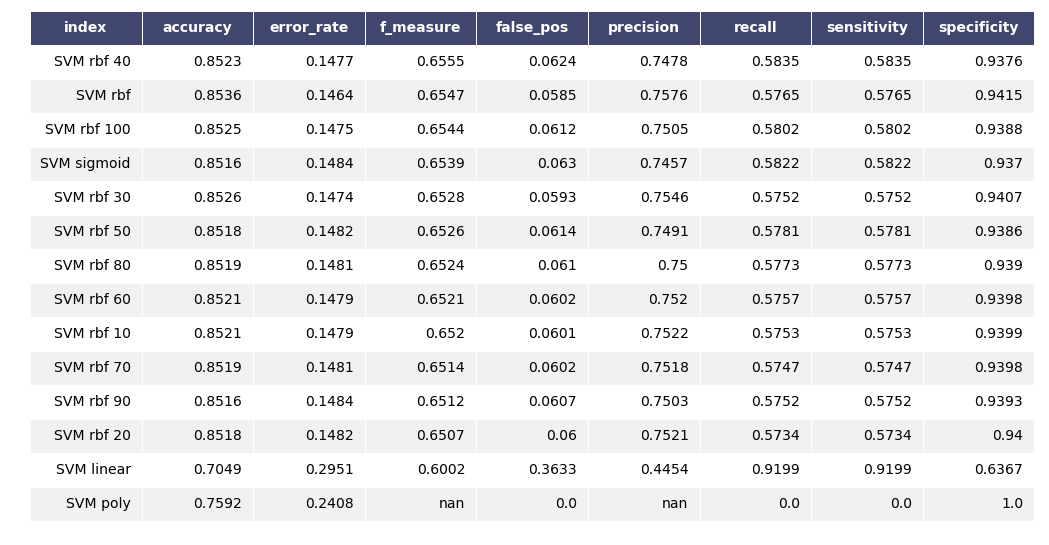

In [24]:
render_mpl_table(ovl_svm.round(4).reset_index(), header_columns=0, col_width=2)
plt.savefig("svm_table.png")

In [29]:
export_csv = ovl_svm.round(4).reset_index().to_csv ('./svmDataFrame.csv', index = None, header=True)
test = pd.read_csv('./svmDataFrame.csv')


,index,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
0,SVM rbf 40,0.8523,0.1477,0.6555,0.0624,0.7478,0.5835,0.5835,0.9376
1,SVM rbf,0.8536,0.1464,0.6547,0.0585,0.7576,0.5765,0.5765,0.9415
2,SVM rbf 100,0.8525,0.1475,0.6544,0.0612,0.7505,0.5802,0.5802,0.9388
3,SVM sigmoid,0.8516,0.1484,0.6539,0.0630,0.7457,0.5822,0.5822,0.9370
4,SVM rbf 30,0.8526,0.1474,0.6528,0.0593,0.7546,0.5752,0.5752,0.9407
5,SVM rbf 50,0.8518,0.1482,0.6526,0.0614,0.7491,0.5781,0.5781,0.9386
6,SVM rbf 80,0.8519,0.1481,0.6524,0.0610,0.7500,0.5773,0.5773,0.9390
7,SVM rbf 60,0.8521,0.1479,0.6521,0.0602,0.7520,0.5757,0.5757,0.9398
8,SVM rbf 10,0.8521,0.1479,0.6520,0.0601,0.7522,0.5753,0.5753,0.9399
9,SVM rbf 70,0.8519,0.1481,0.6514,0.0602,0.7518,0.5747,0.5747,0.9398


In [14]:
def print_metrics(Y_true, Y_pred):
    """Prints metrics comparing true and predicted classifications"""
    
    cm_test = confusion_matrix(y_true=Y_true, y_pred=Y_pred)

    total = cm_test.sum()

    correct = 0
    for i in range(len(cm_test)):
        correct += cm_test[i,i]
    
    acc = correct/total
    
    print("Confusion Matrix:\n")
    print("      predicted class:")
    print("          0\t1")
    print("        _____________")
    print("true  0| {}\t{}".format(cm_test[0,0], cm_test[0,1]))
    print("class 1| {}\t{}".format(cm_test[1,0], cm_test[1,1]))
    print("")
    print("Correct: \t{}".format(correct))
    print("Misclassified: \t{}".format(total-correct))
    print("Accuracy: \t{:.2f}%".format(acc*100))
    print("Error rate: \t{:.2f}%".format((1-acc)*100))
    print("Sensitivity: \t{:.2f}% (true positive)".format(cm_test[1,1]*100 / cm_test[1].sum()))
    print("Specificity: \t{:.2f}% (true negative)".format(cm_test[0,0]*100 / cm_test[0].sum()))
    print("Precision: \t{:.2f}% (positive predict value)".format(100*cm_test[1,1] / cm_test[:,1].sum()))
    print("False Pos: \t{:.2f}%".format(100*cm_test[0,1] / cm_test[0].sum()))

In [16]:
clf = load('svm_rbf.joblib')

In [17]:
y_pred = clf.predict(X_val)

print_metrics(Y_val,y_pred)

Confusion Matrix:

      predicted class:
          0	1
        _____________
true  0| 1196	348
class 1| 194	1262

Correct: 	2458
Misclassified: 	542
Accuracy: 	81.93%
Error rate: 	18.07%
Sensitivity: 	86.68% (true positive)
Specificity: 	77.46% (true negative)
Precision: 	78.39% (positive predict value)
False Pos: 	22.54%
